In [30]:
import sys

sys.path.append("../src/helpers")
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mlflow.tracking import MlflowClient
from scipy.stats import pearsonr
from mlflow_utils import mlflow_tracking_uri

client = MlflowClient(tracking_uri=mlflow_tracking_uri)
experiment_id_mapping = experiment_id_mapping = {
    "cifar10-resnet": "206",
    "cifar100-resnet": "210",
    "mufac-resnet": "208",
    "cifar10-vit": "211",
    "cifar100-vit": "212",
    "mufac-vit": "213",
    "50-cifar10-resnet": "218",
    "50-cifar100-resnet": "219",
    "50-cifar10-vit": "220",
    "50-cifar100-vit": "221",
}


def get_results(experiment_name):
    experiment_id = experiment_id_mapping[experiment_name]
    if "cifar10-resnet" in experiment_name:
        alpha = "8.0"
    else:
        alpha = "2.0"
    methods = [
        "original",
        "retrained",
        "finetune",
        "neggrad",
        "relabel",
        "badT",
        "scrub",
        "ssd",
        "unsir",
    ]
    metrics = [
        "mia",
        "acc_forget",
        "acc_retain",
        "acc_test",
        "acc_val",
        "t",
        "js",
        "js_proxy",
    ]
    runs = client.search_runs(experiment_id)
    df = pd.DataFrame(
        [
            {k: v for k, v in run.data.metrics.items() if k in metrics}
            for run in runs
            if run.data.tags.get("mlflow.runName") in methods
            or (
                run.data.tags.get("mlflow.runName") == "our"
                and run.data.params.get("alpha") == str(alpha)
            )
        ]
    )
    df["method"] = [
        run.data.tags.get("mlflow.runName")
        for run in runs
        if run.data.tags.get("mlflow.runName") in methods
        or (
            run.data.tags.get("mlflow.runName") == "our"
            and run.data.params.get("alpha") == str(alpha)
        )
    ]

    df["seed"] = [
        run.data.params.get("seed")
        for run in runs
        if run.data.tags.get("mlflow.runName") in methods
        or (
            run.data.tags.get("mlflow.runName") == "our"
            and run.data.params.get("alpha") == str(alpha)
        )
    ]

    df.set_index(["method", "seed"], inplace=True)

    grouped_df = df.groupby("method").aggregate(["mean", "std"])
    grouped_df["js"] = grouped_df["js"].apply(lambda x: x * 1e4)
    grouped_df["js_proxy"] = grouped_df["js_proxy"].apply(lambda x: x * 1e4)
    grouped_df = grouped_df.round(2)

    gap_metrics = ["mia", "acc_forget", "acc_retain", "acc_test", "acc_val"]
    for method in [
        "finetune",
        "neggrad",
        "relabel",
        "badT",
        "scrub",
        "ssd",
        "unsir",
        "our",
        "retrained",
    ]:
        for metric in gap_metrics:
            grouped_df.loc[method, f"{metric}_gap"] = abs(
                grouped_df.loc[method, (metric, "mean")]
                - grouped_df.loc["retrained", (metric, "mean")]
            )
    grouped_df["avg_gap"] = (
        grouped_df[
            [
                "mia_gap",
                "acc_retain_gap",
                "acc_forget_gap",
                "acc_test_gap",
            ]
        ]
        .mean(axis=1)
        .round(4)
    )

    main_df = grouped_df.loc[
        [
            "retrained",
            "finetune",
            "neggrad",
            "relabel",
            "badT",
            "scrub",
            "ssd",
            "unsir",
            "our",
        ],
        ["avg_gap", "t", "js", "js_proxy"],
    ]

    appendix_df = grouped_df.loc[
        [
            "original",
            "retrained",
            "finetune",
            "neggrad",
            "relabel",
            "badT",
            "scrub",
            "ssd",
            "unsir",
            "our",
        ],
        [
            "mia",
            "mia_gap",
            "acc_forget",
            "acc_forget_gap",
            "acc_retain",
            "acc_retain_gap",
            "acc_test",
            "acc_test_gap",
            "avg_gap",
        ],
    ]

    print(experiment_name)
    corr, p_value = pearsonr(main_df[("avg_gap", "")], main_df[("js_proxy", "mean")])
    print(
        f"Pearson correlation between avg_gap and js_proxy: {corr:.2f}, p-value: {p_value:.4f}"
    )

    corr, p_value = pearsonr(main_df[("avg_gap", "")], main_df[("js", "mean")])
    print(
        f"Pearson correlation between avg_gap and js: {corr:.2f}, p-value: {p_value:.4f}"
    )

    corr, p_value = pearsonr(main_df[("js", "mean")], main_df[("js_proxy", "mean")])
    print(
        f"Pearson correlation between js and js_proxy: {corr:.2f}, p-value: {p_value:.4f}"
    )

    # Rename columns in main_df
    main_df.columns = [
        "Avg Gap" if col == ("avg_gap", "") else
        f"Time({col[1]})" if col[0] == "t" else
        f"JSD({col[1]})" if col[0] == "js" else
        f"RF-JSD({col[1]})" if col[0] == "js_proxy" else
        col
        for col in main_df.columns
    ]

    main_df.rename(
    index={
        "retrained": "Gold Std",
        "finetune": "Finetuning",
        "neggrad": "NegGrad+",
        "relabel": "Rnd Labeling",
        "badT": "Bad Teacher",
        "scrub": "SCRUB",
        "ssd": "SSD",
        "unsir": "UNSIR",
        "our": "LoTUS",
    },
    inplace=True,
    )

    appendix_df.rename(
    index={
        "original": "Original",
        "retrained": "Gold Std",
        "finetune": "Finetuning",
        "neggrad": "NegGrad+",
        "relabel": "Rnd Labeling",
        "badT": "Bad Teacher",
        "scrub": "SCRUB",
        "ssd": "SSD",
        "unsir": "UNSIR",
        "our": "LoTUS",
    },
    inplace=True,
    )

    display(main_df)
    display(appendix_df)

    return main_df, appendix_df

In [31]:
rn_cifar10, appendix_df = get_results("cifar10-resnet")

cifar10-resnet
Pearson correlation between avg_gap and js_proxy: 0.86, p-value: 0.0029
Pearson correlation between avg_gap and js: 0.96, p-value: 0.0000
Pearson correlation between js and js_proxy: 0.90, p-value: 0.0011


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,5.32,1.18,0.00,0.00,5.97,4.69
Finetuning,0.1375,0.43,0.00,1.03,0.24,81.45,6.53
NegGrad+,0.0975,0.49,0.00,1.06,0.21,80.64,21.01
Rnd Labeling,0.0925,0.57,0.00,1.00,0.26,47.98,3.43
Bad Teacher,0.2650,0.33,0.00,2.39,2.03,287.45,157.93
SCRUB,0.0750,0.58,0.00,0.41,0.09,62.39,5.54
SSD,0.0825,0.54,0.00,0.82,0.57,145.86,152.88
UNSIR,0.1075,0.45,0.00,0.65,0.05,17.29,4.21
LoTUS,0.0375,0.29,0.00,0.30,0.04,15.75,2.24


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.94  0.00     NaN       1.00  0.00            NaN       1.00   
Gold Std      0.76  0.03    0.00       0.91  0.02           0.00       0.99   
Finetuning    0.30  0.26    0.46       0.97  0.01           0.06       0.98   
NegGrad+      0.48  0.50    0.28       0.97  0.01           0.06       0.97   
Rnd Labeling  0.48  0.50    0.28       0.96  0.01           0.05       0.97   
Bad Teacher   0.43  0.37    0.33       0.71  0.18           0.20       0.71   
SCRUB         0.94  0.01    0.18       1.00  0.00           0.09       1.00   
SSD           0.81  0.11    0.05       0.86  0.16           0.05       0.87   
UNSIR         0.46  0.03    0.30       0.93  0.01           0.02       0.93   
LoTUS         0.83  0.01    0.07       0.99  0.01           0.08       0.99   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.00            NaN     0.93  0.01          NaN     NaN  
Gold Std      0.02           0.00     0.91  0.02         0.00  0.0000  
Finetuning    0.01           0.01     0.89  0.02         0.02  0.1375  
NegGrad+      0.01           0.02     0.88  0.02         0.03  0.0975  
Rnd Labeling  0.01           0.02     0.89  0.02         0.02  0.0925  
Bad Teacher   0.18           0.28     0.66  0.16         0.25  0.2650  
SCRUB         0.00           0.01     0.93  0.01         0.02  0.0750  
SSD           0.16           0.12     0.80  0.15         0.11  0.0825  
UNSIR         0.01           0.06     0.86  0.01         0.05  0.1075  
LoTUS         0.00           0.00     0.91  0.01         0.00  0.0375

In [32]:
rn_cifar100, appendix_df = get_results("cifar100-resnet")

cifar100-resnet
Pearson correlation between avg_gap and js_proxy: 0.80, p-value: 0.0092
Pearson correlation between avg_gap and js: 0.87, p-value: 0.0022
Pearson correlation between js and js_proxy: 0.97, p-value: 0.0000


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,3.39,0.30,0.00,0.00,16.34,1.58
Finetuning,0.3600,0.43,0.00,6.88,0.59,101.26,19.61
NegGrad+,0.3575,0.49,0.00,6.87,0.62,101.75,19.85
Rnd Labeling,0.4025,0.57,0.00,5.84,0.98,74.93,20.53
Bad Teacher,0.3675,0.34,0.01,4.30,0.49,63.04,8.91
SCRUB,0.1650,0.58,0.00,1.87,0.08,18.79,1.96
SSD,0.2125,0.54,0.00,3.04,1.55,42.17,36.59
UNSIR,0.3625,0.45,0.00,3.05,0.32,40.02,8.51
LoTUS,0.1025,0.30,0.01,1.29,0.03,8.35,0.19


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.77  0.05     NaN       0.93  0.04            NaN       0.93   
Gold Std      0.49  0.01    0.00       0.57  0.02           0.00       0.94   
Finetuning    0.00  0.00    0.49       0.40  0.06           0.17       0.41   
NegGrad+      0.00  0.00    0.49       0.41  0.06           0.16       0.41   
Rnd Labeling  0.00  0.00    0.49       0.31  0.06           0.26       0.37   
Bad Teacher   0.33  0.58    0.16       0.27  0.03           0.30       0.28   
SCRUB         0.78  0.05    0.29       0.93  0.03           0.36       0.93   
SSD           0.59  0.05    0.10       0.50  0.32           0.07       0.50   
UNSIR         0.00  0.00    0.49       0.40  0.07           0.17       0.41   
LoTUS         0.55  0.01    0.06       0.89  0.04           0.32       0.93   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.03            NaN     0.60  0.02          NaN     NaN  
Gold Std      0.03           0.00     0.60  0.02         0.00  0.0000  
Finetuning    0.06           0.53     0.35  0.05         0.25  0.3600  
NegGrad+      0.06           0.53     0.35  0.05         0.25  0.3575  
Rnd Labeling  0.07           0.57     0.31  0.06         0.29  0.4025  
Bad Teacher   0.03           0.66     0.25  0.03         0.35  0.3675  
SCRUB         0.03           0.01     0.60  0.02         0.00  0.1650  
SSD           0.32           0.44     0.36  0.20         0.24  0.2125  
UNSIR         0.07           0.53     0.34  0.04         0.26  0.3625  
LoTUS         0.03           0.01     0.62  0.01         0.02  0.1025

In [33]:
rn_mufac, appendix_df = get_results("mufac-resnet")

mufac-resnet
Pearson correlation between avg_gap and js_proxy: 0.38, p-value: 0.3107
Pearson correlation between avg_gap and js: 0.77, p-value: 0.0163
Pearson correlation between js and js_proxy: 0.88, p-value: 0.0018


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,7.34,0.77,0.00,0.00,199.05,93.15
Finetuning,0.1525,0.76,0.00,19.52,6.23,1439.18,233.65
NegGrad+,0.1550,0.91,0.00,19.16,5.31,1546.01,156.39
Rnd Labeling,0.1300,1.06,0.00,9.51,2.39,444.89,73.01
Bad Teacher,0.1025,0.66,0.00,9.41,0.04,489.70,12.30
SCRUB,0.1625,1.20,0.00,10.53,2.31,254.92,131.48
SSD,0.1600,1.07,0.00,10.30,2.28,243.30,142.87
UNSIR,0.1450,1.68,0.02,16.32,4.82,988.15,120.39
LoTUS,0.1250,0.62,0.00,6.90,1.49,133.11,45.89


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.70  0.06     NaN       0.88  0.04            NaN       0.89   
Gold Std      0.48  0.04    0.00       0.47  0.04           0.00       0.89   
Finetuning    0.54  0.09    0.06       0.64  0.04           0.17       0.64   
NegGrad+      0.53  0.08    0.05       0.68  0.04           0.21       0.66   
Rnd Labeling  0.33  0.31    0.15       0.66  0.04           0.19       0.80   
Bad Teacher   0.34  0.01    0.14       0.53  0.07           0.06       0.76   
SCRUB         0.70  0.05    0.22       0.88  0.06           0.41       0.89   
SSD           0.70  0.06    0.22       0.87  0.06           0.40       0.89   
UNSIR         0.40  0.35    0.08       0.71  0.03           0.24       0.73   
LoTUS         0.53  0.04    0.05       0.86  0.04           0.39       0.85   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.04            NaN     0.54  0.03          NaN     NaN  
Gold Std      0.04           0.00     0.56  0.02         0.00  0.0000  
Finetuning    0.04           0.25     0.43  0.01         0.13  0.1525  
NegGrad+      0.03           0.23     0.43  0.01         0.13  0.1550  
Rnd Labeling  0.03           0.09     0.47  0.02         0.09  0.1300  
Bad Teacher   0.04           0.13     0.48  0.03         0.08  0.1025  
SCRUB         0.04           0.00     0.54  0.03         0.02  0.1625  
SSD           0.05           0.00     0.54  0.03         0.02  0.1600  
UNSIR         0.03           0.16     0.46  0.01         0.10  0.1450  
LoTUS         0.08           0.04     0.54  0.05         0.02  0.1250

In [34]:
vit_cifar10, appendix_df = get_results("cifar10-vit")

cifar10-vit
Pearson correlation between avg_gap and js_proxy: 0.90, p-value: 0.0011
Pearson correlation between avg_gap and js: 0.98, p-value: 0.0000
Pearson correlation between js and js_proxy: 0.92, p-value: 0.0005


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,111.00,1.99,0.00,0.00,1.66,0.37
Finetuning,0.0075,11.33,0.03,0.01,0.00,3.26,0.68
NegGrad+,0.0125,12.61,0.03,0.03,0.00,6.12,0.25
Rnd Labeling,0.0125,12.78,0.01,0.02,0.01,2.11,0.51
Bad Teacher,0.0375,8.79,0.02,0.12,0.03,9.21,3.18
SCRUB,0.0050,16.66,0.02,0.01,0.00,2.81,0.20
SSD,0.0075,13.65,0.02,0.02,0.01,2.69,0.22
UNSIR,0.0100,10.68,0.02,0.01,0.01,2.41,0.66
LoTUS,0.0050,7.34,0.25,0.01,0.00,2.08,0.29


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.88  0.00     NaN       1.00  0.00            NaN       1.00   
Gold Std      0.88  0.01    0.00       0.99  0.00           0.00       1.00   
Finetuning    0.90  0.00    0.02       0.99  0.00           0.00       1.00   
NegGrad+      0.91  0.00    0.03       1.00  0.00           0.01       1.00   
Rnd Labeling  0.84  0.02    0.04       0.99  0.00           0.00       1.00   
Bad Teacher   0.81  0.02    0.07       0.96  0.01           0.03       0.97   
SCRUB         0.88  0.00    0.00       1.00  0.00           0.01       1.00   
SSD           0.89  0.01    0.01       1.00  0.01           0.01       1.00   
UNSIR         0.90  0.00    0.02       0.99  0.00           0.00       0.99   
LoTUS         0.87  0.00    0.01       1.00  0.00           0.01       1.00   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.00            NaN     0.99  0.01          NaN     NaN  
Gold Std      0.00           0.00     0.98  0.01         0.00  0.0000  
Finetuning    0.00           0.00     0.99  0.00         0.01  0.0075  
NegGrad+      0.00           0.00     0.99  0.01         0.01  0.0125  
Rnd Labeling  0.00           0.00     0.99  0.01         0.01  0.0125  
Bad Teacher   0.01           0.03     0.96  0.01         0.02  0.0375  
SCRUB         0.00           0.00     0.99  0.01         0.01  0.0050  
SSD           0.01           0.00     0.99  0.01         0.01  0.0075  
UNSIR         0.00           0.01     0.99  0.01         0.01  0.0100  
LoTUS         0.00           0.00     0.98  0.01         0.00  0.0050

In [35]:
vit_cifar100, appendix_df = get_results("cifar100-vit")

cifar100-vit
Pearson correlation between avg_gap and js_proxy: 0.72, p-value: 0.0298
Pearson correlation between avg_gap and js: 0.93, p-value: 0.0003
Pearson correlation between js and js_proxy: 0.84, p-value: 0.0043


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,112.25,0.13,0.00,0.00,2.58,0.08
Finetuning,0.0275,11.35,0.00,0.07,0.00,3.12,0.17
NegGrad+,0.0325,12.63,0.01,0.13,0.01,3.37,0.12
Rnd Labeling,0.0175,12.79,0.02,0.06,0.00,2.74,0.17
Bad Teacher,0.0375,9.18,0.27,0.17,0.01,3.80,0.22
SCRUB,0.0200,16.74,0.03,0.04,0.00,2.04,0.09
SSD,0.0175,13.67,0.02,0.04,0.00,2.08,0.13
UNSIR,0.0250,10.69,0.01,0.08,0.01,3.11,0.19
LoTUS,0.0125,7.02,0.01,0.03,0.00,1.89,0.07


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.75  0.00     NaN       0.97  0.01            NaN       0.96   
Gold Std      0.72  0.00    0.00       0.92  0.00           0.00       0.96   
Finetuning    0.77  0.00    0.05       0.95  0.01           0.03       0.98   
NegGrad+      0.79  0.02    0.07       0.97  0.02           0.05       0.97   
Rnd Labeling  0.74  0.01    0.02       0.94  0.00           0.02       0.98   
Bad Teacher   0.66  0.01    0.06       0.90  0.01           0.02       0.91   
SCRUB         0.75  0.00    0.03       0.97  0.00           0.05       0.96   
SSD           0.75  0.01    0.03       0.96  0.01           0.04       0.96   
UNSIR         0.78  0.01    0.06       0.94  0.00           0.02       0.95   
LoTUS         0.73  0.00    0.01       0.96  0.01           0.04       0.96   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.00            NaN     0.91  0.01          NaN     NaN  
Gold Std      0.00           0.00     0.91  0.00         0.00  0.0000  
Finetuning    0.00           0.02     0.92  0.01         0.01  0.0275  
NegGrad+      0.02           0.01     0.91  0.01         0.00  0.0325  
Rnd Labeling  0.00           0.02     0.92  0.00         0.01  0.0175  
Bad Teacher   0.00           0.05     0.89  0.01         0.02  0.0375  
SCRUB         0.00           0.00     0.91  0.01         0.00  0.0200  
SSD           0.00           0.00     0.91  0.00         0.00  0.0175  
UNSIR         0.01           0.01     0.90  0.01         0.01  0.0250  
LoTUS         0.00           0.00     0.91  0.00         0.00  0.0125

In [36]:
vit_mufac, appendix_df = get_results("mufac-vit")

mufac-vit
Pearson correlation between avg_gap and js_proxy: 0.97, p-value: 0.0000
Pearson correlation between avg_gap and js: 0.96, p-value: 0.0000
Pearson correlation between js and js_proxy: 0.93, p-value: 0.0003


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,13.83,0.01,0.00,0.00,12.89,0.10
Finetuning,0.0400,1.40,0.01,0.27,0.02,18.46,6.75
NegGrad+,0.0475,1.67,0.00,0.39,0.04,20.68,6.78
Rnd Labeling,0.0200,1.76,0.01,0.35,0.09,22.58,3.92
Bad Teacher,0.1750,2.09,0.25,1.89,1.01,201.41,191.09
SCRUB,0.0200,2.21,0.01,0.05,0.02,8.27,0.60
SSD,0.0200,1.91,0.00,0.17,0.17,14.89,9.32
UNSIR,0.0475,3.21,0.01,0.85,0.06,23.52,8.34
LoTUS,0.0200,1.09,0.00,0.05,0.01,10.11,0.54


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.58  0.01     NaN       0.63  0.01            NaN       0.66   
Gold Std      0.57  0.00    0.00       0.57  0.01           0.00       0.66   
Finetuning    0.52  0.08    0.05       0.61  0.01           0.04       0.72   
NegGrad+      0.52  0.07    0.05       0.66  0.02           0.09       0.71   
Rnd Labeling  0.52  0.10    0.05       0.58  0.01           0.01       0.67   
Bad Teacher   0.35  0.05    0.22       0.43  0.06           0.14       0.47   
SCRUB         0.59  0.01    0.02       0.62  0.01           0.05       0.66   
SSD           0.59  0.01    0.02       0.59  0.04           0.02       0.63   
UNSIR         0.47  0.08    0.10       0.58  0.01           0.01       0.72   
LoTUS         0.59  0.01    0.02       0.63  0.00           0.06       0.66   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.01            NaN     0.66  0.01          NaN     NaN  
Gold Std      0.01           0.00     0.65  0.01         0.00  0.0000  
Finetuning    0.01           0.06     0.66  0.01         0.01  0.0400  
NegGrad+      0.01           0.05     0.65  0.03         0.00  0.0475  
Rnd Labeling  0.02           0.01     0.64  0.01         0.01  0.0200  
Bad Teacher   0.07           0.19     0.50  0.08         0.15  0.1750  
SCRUB         0.01           0.00     0.66  0.01         0.01  0.0200  
SSD           0.04           0.03     0.64  0.01         0.01  0.0200  
UNSIR         0.01           0.06     0.63  0.02         0.02  0.0475  
LoTUS         0.01           0.00     0.65  0.01         0.00  0.0200

# Scaling up forget set to 50% of the training set.

In [40]:
rn50_cifar10, appendix_df = get_results("50-cifar10-resnet")

50-cifar10-resnet
Pearson correlation between avg_gap and js_proxy: 0.74, p-value: 0.0234
Pearson correlation between avg_gap and js: 0.90, p-value: 0.0010
Pearson correlation between js and js_proxy: 0.89, p-value: 0.0013


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,2.52,0.26,0.00,0.00,14.50,0.31
Finetuning,0.1100,0.26,0.01,0.31,0.00,34.78,7.45
NegGrad+,0.1475,0.51,0.02,0.31,0.01,32.29,4.88
Rnd Labeling,0.2100,0.48,0.00,0.73,0.22,525.89,202.57
Bad Teacher,0.0625,0.57,0.02,0.18,0.02,13.22,3.10
SCRUB,0.1075,0.61,0.02,0.14,0.00,56.79,4.83
SSD,0.1025,1.27,0.02,0.13,0.00,42.11,6.47
UNSIR,0.1025,0.73,0.00,0.21,0.05,14.82,4.96
LoTUS,0.0650,0.57,0.00,0.09,0.01,11.15,1.41


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.94  0.00     NaN       1.00  0.00            NaN       1.00   
Gold Std      0.73  0.01    0.00       0.86  0.01           0.00       0.98   
Finetuning    0.44  0.01    0.29       0.97  0.01           0.11       0.97   
NegGrad+      0.29  0.25    0.44       0.97  0.01           0.11       0.97   
Rnd Labeling  0.87  0.23    0.14       0.69  0.09           0.17       0.69   
Bad Teacher   0.59  0.17    0.14       0.92  0.02           0.06       0.93   
SCRUB         0.93  0.01    0.20       1.00  0.00           0.14       1.00   
SSD           0.92  0.01    0.19       1.00  0.00           0.14       1.00   
UNSIR         0.45  0.05    0.28       0.94  0.02           0.08       0.94   
LoTUS         0.79  0.02    0.06       0.99  0.01           0.13       0.99   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.00            NaN     0.93  0.01          NaN     NaN  
Gold Std      0.01           0.00     0.86  0.01         0.00  0.0000  
Finetuning    0.01           0.01     0.89  0.01         0.03  0.1100  
NegGrad+      0.01           0.01     0.89  0.01         0.03  0.1475  
Rnd Labeling  0.09           0.29     0.62  0.07         0.24  0.2100  
Bad Teacher   0.02           0.05     0.86  0.02         0.00  0.0625  
SCRUB         0.00           0.02     0.93  0.01         0.07  0.1075  
SSD           0.00           0.02     0.92  0.01         0.06  0.1025  
UNSIR         0.02           0.04     0.87  0.02         0.01  0.1025  
LoTUS         0.00           0.01     0.92  0.01         0.06  0.0650

In [41]:
rn50_cifar100, appendix_df = get_results("50-cifar100-resnet")

50-cifar100-resnet
Pearson correlation between avg_gap and js_proxy: 0.79, p-value: 0.0118
Pearson correlation between avg_gap and js: 0.80, p-value: 0.0103
Pearson correlation between js and js_proxy: 0.91, p-value: 0.0006


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,1.94,0.06,0.00,0.00,11.85,0.36
Finetuning,0.3200,0.26,0.01,1.39,0.10,70.78,16.60
NegGrad+,0.3150,0.52,0.00,1.38,0.08,70.30,15.65
Rnd Labeling,0.3875,0.48,0.00,1.03,0.23,72.42,28.15
Bad Teacher,0.3050,0.58,0.01,0.55,0.04,49.23,5.14
SCRUB,0.2225,0.62,0.00,0.44,0.02,15.02,2.15
SSD,0.2225,1.29,0.03,0.44,0.02,15.06,2.17
UNSIR,0.2925,0.72,0.01,0.65,0.23,33.83,3.26
LoTUS,0.1725,0.57,0.01,0.28,0.00,7.66,0.26


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.78  0.04     NaN       0.93  0.03            NaN       0.93   
Gold Std      0.41  0.01    0.00       0.52  0.01           0.00       0.98   
Finetuning    0.00  0.00    0.41       0.41  0.06           0.11       0.41   
NegGrad+      0.00  0.00    0.41       0.42  0.06           0.10       0.42   
Rnd Labeling  0.00  0.00    0.41       0.30  0.10           0.22       0.33   
Bad Teacher   0.67  0.58    0.26       0.36  0.05           0.16       0.38   
SCRUB         0.78  0.04    0.37       0.93  0.03           0.41       0.93   
SSD           0.78  0.04    0.37       0.93  0.03           0.41       0.93   
UNSIR         0.00  0.00    0.41       0.45  0.06           0.07       0.46   
LoTUS         0.57  0.02    0.16       0.91  0.03           0.39       0.92   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.03            NaN     0.60  0.02          NaN     NaN  
Gold Std      0.01           0.00     0.54  0.01         0.00  0.0000  
Finetuning    0.07           0.57     0.35  0.05         0.19  0.3200  
NegGrad+      0.06           0.56     0.35  0.05         0.19  0.3150  
Rnd Labeling  0.11           0.65     0.27  0.09         0.27  0.3875  
Bad Teacher   0.05           0.60     0.34  0.04         0.20  0.3050  
SCRUB         0.03           0.05     0.60  0.02         0.06  0.2225  
SSD           0.03           0.05     0.60  0.02         0.06  0.2225  
UNSIR         0.06           0.52     0.37  0.04         0.17  0.2925  
LoTUS         0.03           0.06     0.62  0.02         0.08  0.1725

In [42]:
vit50_cifar10, appendix_df = get_results("50-cifar10-vit")

50-cifar10-vit
Pearson correlation between avg_gap and js_proxy: 0.96, p-value: 0.0000
Pearson correlation between avg_gap and js: 0.96, p-value: 0.0001
Pearson correlation between js and js_proxy: 0.99, p-value: 0.0000


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,64.09,2.60,0.00,0.00,1.19,0.24
Finetuning,0.0125,6.48,0.27,0.00,0.00,1.83,0.12
NegGrad+,0.0200,12.97,0.50,0.01,0.00,5.67,0.56
Rnd Labeling,0.0050,12.60,0.03,0.00,0.00,1.46,0.10
Bad Teacher,0.0600,15.10,0.20,0.04,0.01,28.75,4.47
SCRUB,0.0125,16.99,0.35,0.00,0.00,2.40,0.21
SSD,0.0150,19.03,0.54,0.00,0.00,2.38,0.25
UNSIR,0.0150,18.33,0.02,0.00,0.00,1.31,0.16
LoTUS,0.0050,14.09,0.53,0.00,0.00,1.18,0.17


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.87  0.01     NaN       1.00  0.00            NaN       1.00   
Gold Std      0.84  0.01    0.00       0.99  0.01           0.00       1.00   
Finetuning    0.88  0.01    0.04       0.99  0.00           0.00       1.00   
NegGrad+      0.90  0.00    0.06       1.00  0.00           0.01       1.00   
Rnd Labeling  0.82  0.02    0.02       0.99  0.00           0.00       1.00   
Bad Teacher   0.76  0.01    0.08       0.93  0.01           0.06       0.95   
SCRUB         0.87  0.01    0.03       1.00  0.00           0.01       1.00   
SSD           0.88  0.01    0.04       1.00  0.00           0.01       1.00   
UNSIR         0.89  0.00    0.05       0.99  0.00           0.00       0.99   
LoTUS         0.83  0.01    0.01       1.00  0.00           0.01       1.00   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.00            NaN     0.99  0.01          NaN     NaN  
Gold Std      0.00           0.00     0.98  0.00         0.00  0.0000  
Finetuning    0.00           0.00     0.99  0.01         0.01  0.0125  
NegGrad+      0.00           0.00     0.99  0.00         0.01  0.0200  
Rnd Labeling  0.00           0.00     0.98  0.01         0.00  0.0050  
Bad Teacher   0.01           0.05     0.93  0.01         0.05  0.0600  
SCRUB         0.00           0.00     0.99  0.01         0.01  0.0125  
SSD           0.00           0.00     0.99  0.01         0.01  0.0150  
UNSIR         0.00           0.01     0.98  0.00         0.00  0.0150  
LoTUS         0.00           0.00     0.98  0.01         0.00  0.0050

In [43]:
vit50_cifar100, appendix_df = get_results("50-cifar100-vit")

50-cifar100-vit
Pearson correlation between avg_gap and js_proxy: 0.65, p-value: 0.0600
Pearson correlation between avg_gap and js: 0.81, p-value: 0.0084
Pearson correlation between js and js_proxy: 0.94, p-value: 0.0001


,Avg Gap,Time(mean),Time(std),JSD(mean),JSD(std),RF-JSD(mean),RF-JSD(std)
method,,,,,,,
Gold Std,0.0000,62.71,0.11,0.00,0.00,1.93,0.09
Finetuning,0.0400,6.34,0.01,0.02,0.00,1.90,0.08
NegGrad+,0.0600,12.68,0.02,0.03,0.01,2.96,0.19
Rnd Labeling,0.0250,12.62,0.02,0.01,0.01,1.60,0.08
Bad Teacher,0.0575,15.04,0.03,0.06,0.01,4.63,0.32
SCRUB,0.0350,16.82,0.03,0.01,0.00,1.54,0.06
SSD,0.0350,18.69,0.06,0.01,0.00,1.53,0.07
UNSIR,0.0375,18.33,0.02,0.02,0.00,2.07,0.12
LoTUS,0.0225,13.79,0.02,0.01,0.00,1.44,0.10


mia       mia_gap acc_forget       acc_forget_gap acc_retain  \
              mean   std               mean   std                      mean   
method                                                                        
Original      0.75  0.00     NaN       0.96  0.00            NaN       0.96   
Gold Std      0.68  0.00    0.00       0.91  0.01           0.00       0.95   
Finetuning    0.75  0.01    0.07       0.94  0.00           0.03       0.99   
NegGrad+      0.80  0.00    0.12       0.98  0.00           0.07       0.98   
Rnd Labeling  0.72  0.01    0.04       0.94  0.00           0.03       0.97   
Bad Teacher   0.65  0.01    0.03       0.85  0.01           0.06       0.87   
SCRUB         0.75  0.00    0.07       0.96  0.00           0.05       0.96   
SSD           0.75  0.00    0.07       0.96  0.00           0.05       0.96   
UNSIR         0.78  0.01    0.10       0.94  0.01           0.03       0.96   
LoTUS         0.70  0.00    0.02       0.96  0.00           0.05       0.96   

                   acc_retain_gap acc_test       acc_test_gap avg_gap  
               std                    mean   std                       
method                                                                 
Original      0.00            NaN     0.91  0.01          NaN     NaN  
Gold Std      0.00           0.00     0.90  0.00         0.00  0.0000  
Finetuning    0.01           0.04     0.92  0.01         0.02  0.0400  
NegGrad+      0.00           0.03     0.92  0.00         0.02  0.0600  
Rnd Labeling  0.01           0.02     0.91  0.01         0.01  0.0250  
Bad Teacher   0.01           0.08     0.84  0.00         0.06  0.0575  
SCRUB         0.00           0.01     0.91  0.01         0.01  0.0350  
SSD           0.00           0.01     0.91  0.01         0.01  0.0350  
UNSIR         0.00           0.01     0.91  0.00         0.01  0.0375  
LoTUS         0.01           0.01     0.91  0.00         0.01  0.0225

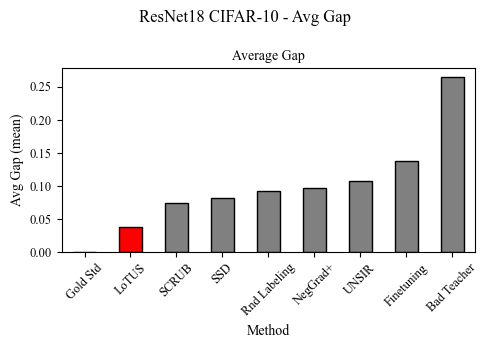

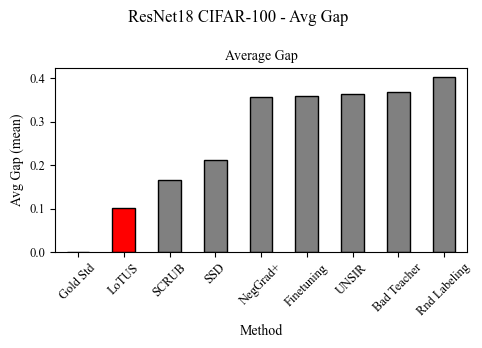

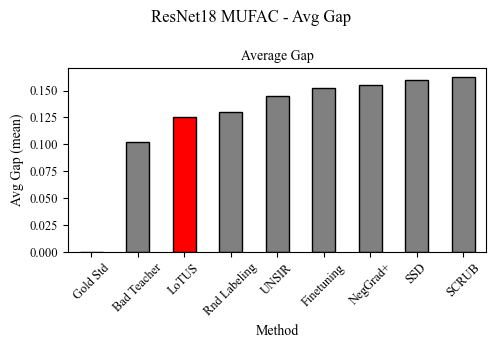

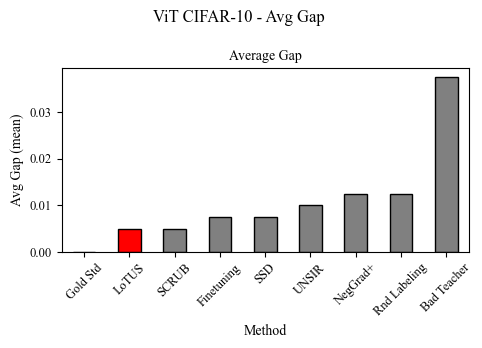

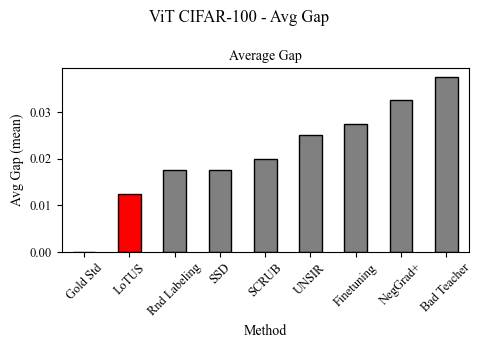

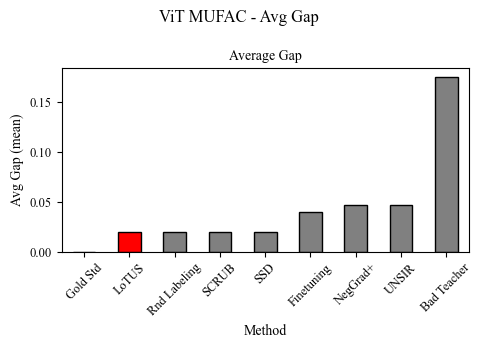

In [49]:
def plot_avg_gap(df, title):
    df_sorted = df.sort_values(by="Avg Gap", ascending=True)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    fig.suptitle(title, fontsize=12, fontname="Times New Roman")

    # Sort by value
    df_sorted = df.sort_values(
        by="Avg Gap",
        ascending=True,
        key=lambda x: x.where(df.index != "LoTUS", x - 0.0001),
    )
    # Define colors for the bars
    colors = ["red" if method == "LoTUS" else "gray" for method in df_sorted.index]

    df_sorted["Avg Gap"].plot(kind="bar", ax=ax, color=colors, edgecolor="black")
    ax.set_title("Average Gap", fontsize=10, fontname="Times New Roman")
    ax.set_xlabel("Method", fontsize=10, fontname="Times New Roman")
    ax.set_ylabel("Avg Gap (mean)", fontsize=10, fontname="Times New Roman")
    ax.tick_params(axis="x", rotation=45, labelsize=9)
    ax.tick_params(axis="y", labelsize=9)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname("Times New Roman")

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


# Plot avg_gap for each dataframe
plot_avg_gap(rn_cifar10, "ResNet18 CIFAR-10 - Avg Gap")
plot_avg_gap(rn_cifar100, "ResNet18 CIFAR-100 - Avg Gap")
plot_avg_gap(rn_mufac, "ResNet18 MUFAC - Avg Gap")
plot_avg_gap(vit_cifar10, "ViT CIFAR-10 - Avg Gap")
plot_avg_gap(vit_cifar100, "ViT CIFAR-100 - Avg Gap")
plot_avg_gap(vit_mufac, "ViT MUFAC - Avg Gap")

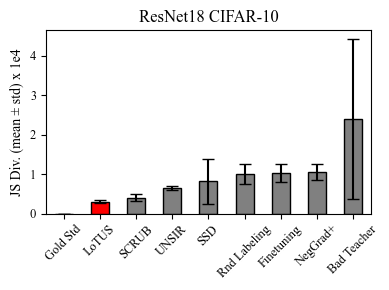

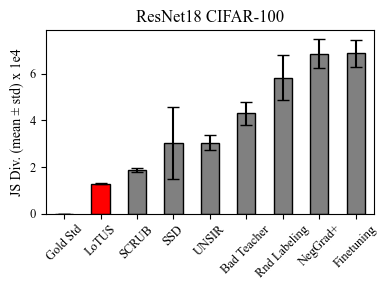

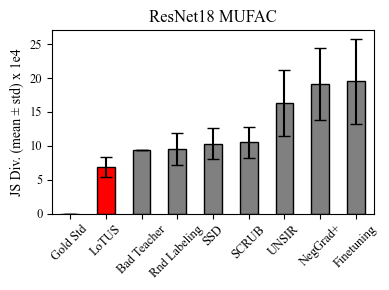

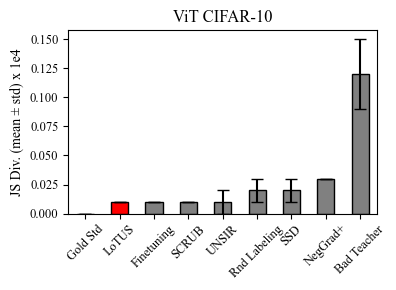

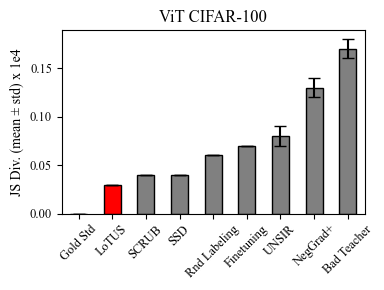

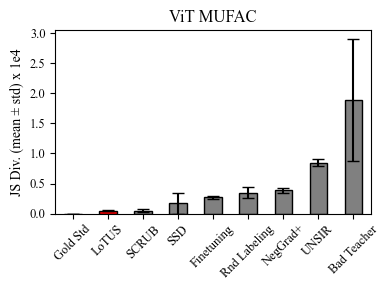

In [54]:
def plot_js_divergence(df, title):
    df_sorted_js = df.sort_values(by="JSD(mean)", ascending=True, key=lambda x: x.where(df.index != 'LoTUS', x - 0.0001))

    fig, ax = plt.subplots(figsize=(4, 3))

    # Define colors for the bars
    colors_js = ['red' if method == 'LoTUS' else 'gray' for method in df_sorted_js.index]

    # Plot js
    df_sorted_js["JSD(mean)"].plot(kind='bar', yerr=df_sorted_js["JSD(std)"], ax=ax, color=colors_js, edgecolor='black', capsize=4)
    ax.set_title(title, fontsize=12, fontname='Times New Roman')
    ax.set_xlabel(None)
    ax.set_ylabel('JS Div. (mean ± std) x 1e4', fontsize=10, fontname='Times New Roman')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Times New Roman')

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'images/{title}_js_divergence.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot JS divergence for each dataframe
plot_js_divergence(rn_cifar10, "ResNet18 CIFAR-10")
plot_js_divergence(rn_cifar100, "ResNet18 CIFAR-100")
plot_js_divergence(rn_mufac, "ResNet18 MUFAC")
plot_js_divergence(vit_cifar10, "ViT CIFAR-10")
plot_js_divergence(vit_cifar100, "ViT CIFAR-100")
plot_js_divergence(vit_mufac, "ViT MUFAC")

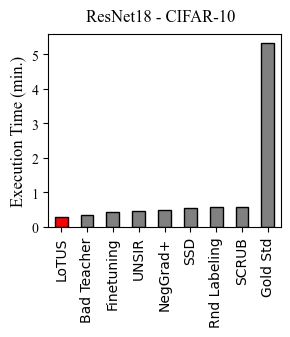

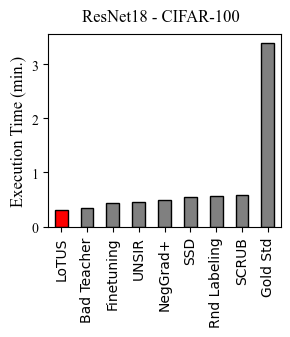

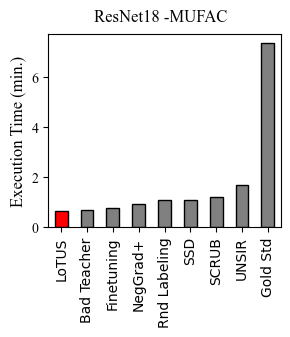

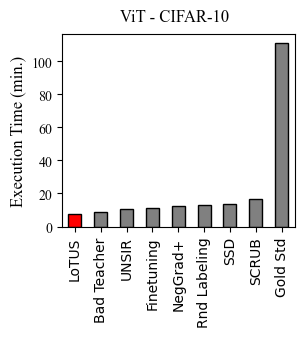

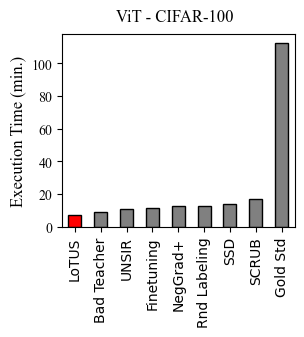

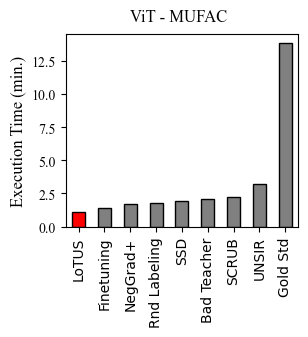

In [57]:
def plot_time(df, title):
    df_sorted = df.sort_values(by="Time(mean)", ascending=True)

    fig, ax = plt.subplots(figsize=(3, 2.5))
    fig.suptitle(title, fontsize=12, fontname="Times New Roman")

    # Sort by value
    df_sorted = df.sort_values(
        by="Time(mean)",
        ascending=True,
        key=lambda x: x.where(df.index != "LoTUS", x - 1e-32),
    )
    # Define colors for the bars
    colors = ["red" if method == "LoTUS" else "grey" for method in df_sorted.index]

    df_sorted["Time(mean)"].plot(kind="bar", ax=ax, color=colors, edgecolor="black")
    ax.set_xlabel(None)
    ax.set_ylabel("Execution Time (min.)", fontsize=12, fontname="Times New Roman")
    ax.tick_params(axis="y", labelsize=10)
    for label in ax.get_yticklabels():
        label.set_fontname("Times New Roman")
    plt.savefig(f'images/time/{title}.png', bbox_inches='tight', dpi=300)
    plt.show()


# Plot (t, mean) for each dataframe
plot_time(rn_cifar10, "ResNet18 - CIFAR-10")
plot_time(rn_cifar100, "ResNet18 - CIFAR-100")
plot_time(rn_mufac, "ResNet18 -MUFAC")
plot_time(vit_cifar10, "ViT - CIFAR-10")
plot_time(vit_cifar100, "ViT - CIFAR-100")
plot_time(vit_mufac, "ViT - MUFAC")